<a href="https://colab.research.google.com/github/candiceevemiller/personal-projects/blob/main/Deep_Dream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image

393216/379198 [===============================] - 0s 0us/step


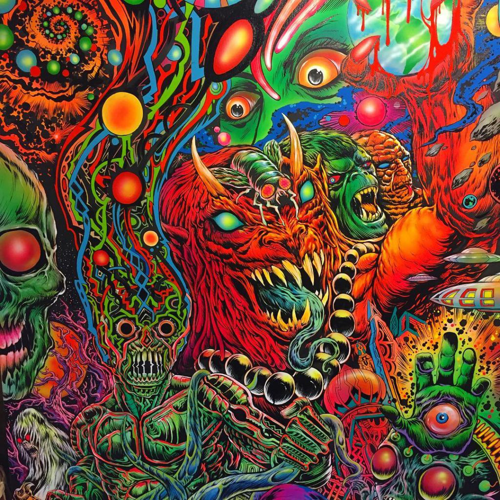

In [ ]:
# url = 'https://www.timeforkids.com/wp-content/uploads/2017/08/170227012793_hero.jpg'  # camel original
# url = 'https://i.imgur.com/9AaPtlE.png'  # we have to go deeper (camels again)
url = 'https://www.theartofskinner.com/wp-content/uploads/2018/10/painting-1024x1024.jpg' #psychedelic art orig
# url = 'https://i.imgur.com/HuMSLjt.png'  # psych second pass
# url = 'https://i.imgur.com/YuJJxtS.jpg'  # cooper orig
# url = 'https://i.imgur.com/YsFdjVw.png'  # cooper second pass

# Download image and read it into a NumPy array
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

original_img = download(url, max_dim=500)
show(original_img)

In [ ]:
inception_net = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
inception_net.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [ ]:
# Maximize the activations of these layers
names = ['mixed7', 'mixed8', 'mixed9', 'mixed10']
layers = [inception_net.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=inception_net.input, outputs=layers)

In [ ]:
def calc_loss(img, model):
  # Pass the image through model to retrieve activations
  # Converts to batch size of 1
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)
  
  return tf.reduce_sum(losses)

In [ ]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
          tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
          tf.TensorSpec(shape=[], dtype=tf.int32),
          tf.TensorSpec(shape=[], dtype=tf.float32)
      )
  )

  def __call__(self, img, steps, step_size):
    print("Tracing")
    loss = tf.constant(0.0)
    for n in tf.range(steps):
      with tf.GradientTape() as tape:
        tape.watch(img)
        loss = calc_loss(img, self.model)

      gradients = tape.gradient(loss, img)

      gradients /= tf.math.reduce_std(gradients) + 1e-8

      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

    return loss, img

In [ ]:
deepdream = DeepDream(dream_model)

In [ ]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to range expected by model
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining > 100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print(f'Step {step}, loss {loss}')
  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

In [ ]:
dream_img = run_deep_dream_simple(img=original_img, steps=100, step_size=0.01)

Tracing


KeyboardInterrupt: ignored

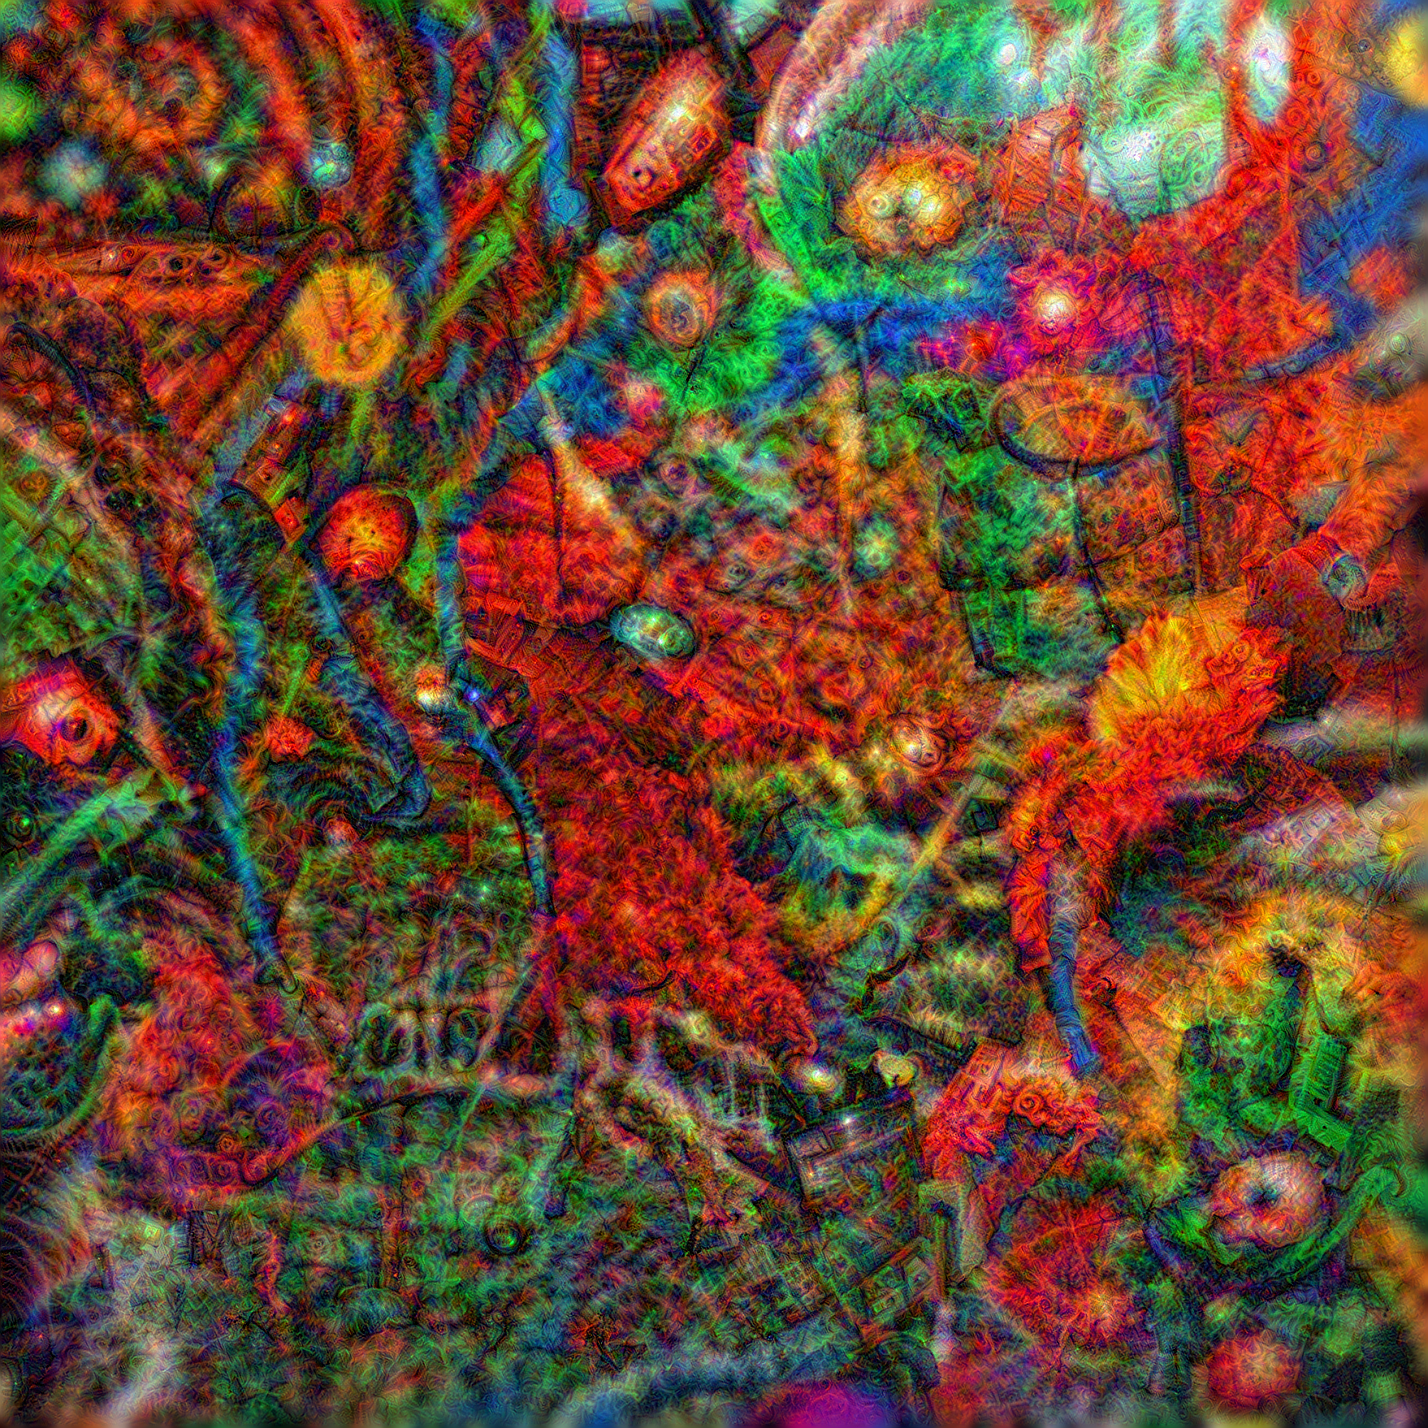

63.68021202087402

In [ ]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-5, 5):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=100, step_size=0.01)

img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)

end = time.time()
end-start